# Use cases in high energy physics


The present chapter makes use of the concept previously introduced to perform computation that one would do in high energy (collider) physics. Indeed, in order to study collisions, one has to loop over several objects inside the collision, group them by pair, check which pair has the smallest angle, etc ... Since we want to use the full power of numpy, all these computation cannot be done with explicit loop over events and/or over objects. This chapter consider few of these typical use cases and their implementation using numpy, using a simple toy dataset made by hand. The case of more realistic collider data is treated in the next chapter.

Let's first perform the usual imports:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Then, one can setup he default matplolib style for all following plots (more details on available option can be found on [how to customize matplotlib](https://matplotlib.org/users/customizing.html)): 

In [2]:
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

## Data model and goals

We consider 1 millions observations, each defined by ten 3D vectors $(r_0,...,r_9)$ where $r_i=(x,y,z)$ (arrow for vector will be omitted from now on). These pseudo-data can represent position in space or RGB colors. This is just an example to play with and apply numpy concepts for both simple computations (element-by-element functions, statistics calculations) and more complex computation exploiting the multi-dimensional structure of the data. For example, one might want to compute the distance between all pairs $(r_i, r_j)$, which has to be done without loop.

Using the `np.random` module, it is possible to generate n-dimensional arrays easily. In our case, we want to generate an array containing our observations with have 3 dimensions (or *axis* in numpy language), and the size along each of these axis will have the following value and meaning:
   
  + `axis=0`: over 1 million events
  + `axis=1`: over 10 vectors
  + `axis=2`: over 3 coordinates

In [3]:
r = np.random.random_sample((1000000, 10, 3))

It is possible to print the first two observations as follow:

In [4]:
print(r[0:2])

[[[0.15624688 0.65075903 0.73146179]
  [0.73724685 0.48307419 0.77974699]
  [0.20971887 0.59327557 0.6531156 ]
  [0.35159907 0.52204891 0.25537105]
  [0.48437309 0.82028797 0.30840494]
  [0.02253355 0.74355187 0.49186388]
  [0.89405241 0.17862992 0.82465271]
  [0.89267253 0.72194804 0.58563866]
  [0.80358019 0.36464842 0.67233442]
  [0.25564683 0.6235393  0.74733499]]

 [[0.91650213 0.05817777 0.01940356]
  [0.70698068 0.85873894 0.84390599]
  [0.86004332 0.36252308 0.98642545]
  [0.40568495 0.01213849 0.67142505]
  [0.42802106 0.34523561 0.97850495]
  [0.41930931 0.59545754 0.11757192]
  [0.03047176 0.5600329  0.66797962]
  [0.6613735  0.9528616  0.23113316]
  [0.56349177 0.31426095 0.43091974]
  [0.25061127 0.91620815 0.32174233]]]


## Mean over the differents axis

### Mean over observations (axis=0)

This mean will average all observations *i.e.* over the first dimension, returning an array of dimension `(10, 3)` corresponding to the average $r_{i}=(x_i,y_i,z_i)$ over the observations.

In [5]:
m0 = np.mean(r, axis=0)
print(m0.shape)

(10, 3)


Note the computation time of 30ms for 30 averages over a million number:

In [6]:
%timeit np.mean(r, axis=0)

44.7 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


While it takes 10 times longer for a *single mean* over a million number with an explicit loop, so **the gain of vectorization is a factor 300**: 

In [7]:
def explicit_loop(array):
    res=0
    for a in array:
        res += a/len(array)

%timeit explicit_loop(np.random.random_sample(size=1000000))

415 ms ± 6.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The distributions of `m0` obtained with `plt.hist()` results into three separate histograms (one for each $x,y,x$) each having 10 entries (one per $r_i$):

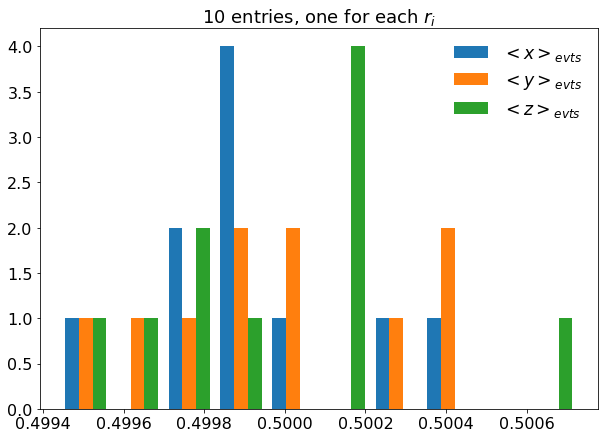

In [10]:
plt.hist(m0, label=['$<x>_{evts}$', '$<y>_{evts}$', '$<z>_{evts}$'])
plt.title('10 entries, one for each $r_i$')
plt.legend();

### Mean over the 10 vectors (axis=1)

This one will compute the average over the 10 vectors, for each observations, reducing into a `(1000000, 3)` shape array, as seen below. This is 3D barycenter of each observation.

In [9]:
m1 = np.mean(r, axis=1)
print(m1.shape)

(1000000, 3)


One can plot the obtained array `m1` using `plt.hist()`, which results into 3 histograms of a million entry each:

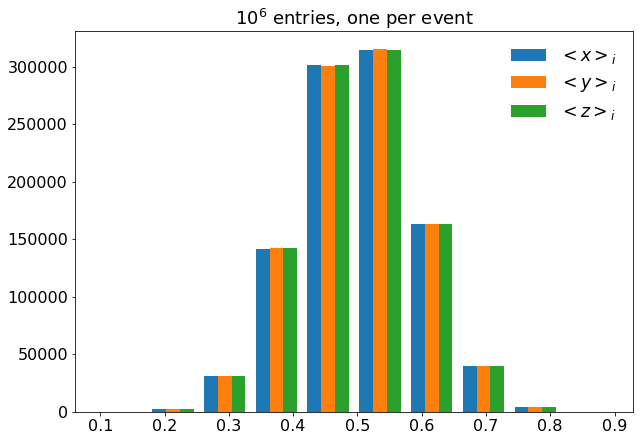

In [11]:
plt.hist(m1, label=['$<x>_{i}$', '$<y>_{i}$', '$<z>_{i}$'])
plt.title('$10^6$ entries, one per event')
plt.legend();

### Mean over the coordintates (axis=2)

This directly computes the average over the three coordinates $(x+y+z)/3$ for each vector of each event, resulting in 10 values per event:

In [13]:
m2 = np.mean(r, axis=2)
print(m2.shape)

(1000000, 10)


The `plt.hist()` of the resulting array `m2` corresponds then to 10 histograms of a million entries each:

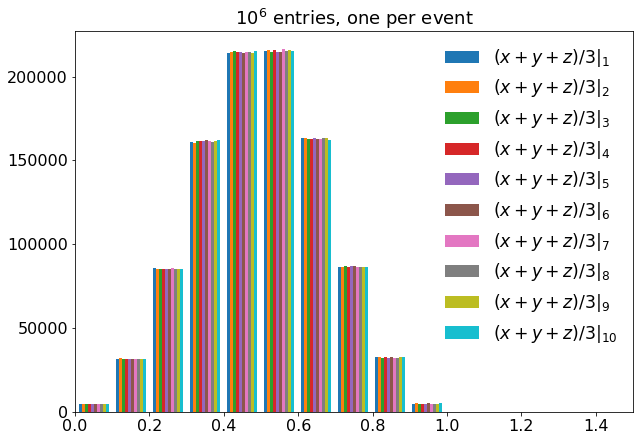

In [14]:
names = ['$(x+y+z)/3|_{'+'{}'.format(i)+'}$' for i in range(1, 11)]
plt.hist(m2, label=names)
plt.title('$10^6$ entries, one per event')
plt.xlim(0, 1.5)
plt.legend();

## Distance computation


Computing particular distances inside a given event is relevant for many applications (distances here can be seen as any type of metric). For example, these computation are crucial in learning algorithms based on nearest neighbor approach. In collider physics, it's always useful to compute angle between two objects (tracks, deposit, particles, ...) in order to compute invariant masses, or isolation in a given cone, etc ...

### Distance to a reference $r_0$

We can start simple by defining a new origin `r0`

In [15]:
r0 = np.array([1, 2, 1])

and compute the distance to this new origin for all points, using `**2` to square all numbers, perform the sum over the coordinate (`axis=2`) and square-root everything with `**0.5`:

In [16]:
d = np.sum((r-r0)**2, axis=2)**0.5
print(d.shape)

(1000000, 10)


As expected the result is 10 numbers for each of the events, which can be easily plotted:

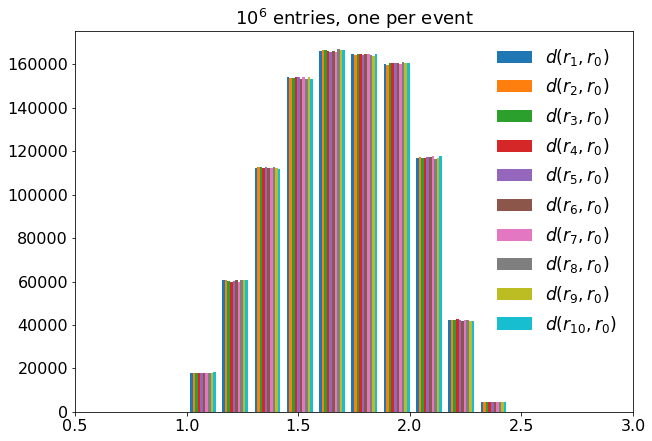

In [17]:
names = ['$d(r_{'+'{}'.format(i)+'},r_0)$' for i in range(1, 11)]
plt.hist(d, label=names)
plt.title('$10^6$ entries, one per event')
plt.xlim(0.5, 3)
plt.legend();

### Distance between  $r_i$ and $<r>_{i}$ for each event

Another calculation is to compute the averaged position for each event and see how distant each vector is from this position. To perform such a calculation, we will use numpy array broadcasting. Let's first compute the average position for every events:

In [18]:
r_mean = np.mean(r, axis=1)

Now, let's broadcast this array  of shape `(1e6, 3)` with the full dataset, *i.e.* an array of shape `(1e6, 10, 3)`, by computing the distance for each point:

In [19]:
try:
    d_to_mean = np.sum((r-r_mean)**2, axis=2)**0.5
except ValueError:
    print('Impossible for {} and {}'.format(r.shape, r_mean.shape))

Impossible for (1000000, 10, 3) and (1000000, 3)


There is one missing dimension, describing the 10 positions, which has to be created so that the array can be copied 10 times over along this dimension:

In [20]:
r_mean_3d = r_mean[:, np.newaxis, :]

We can now retry the operation:

In [21]:
try:
    d_to_mean = np.sum((r-r_mean_3d)**2, axis=2)**0.5
    print('Possible for {} and {}:'.format(r.shape, r_mean_3d.shape))
except ValueError:
    print('Impossible for {} and {}'.format(r.shape, r_mean_3d.shape))

Possible for (1000000, 10, 3) and (1000000, 1, 3):


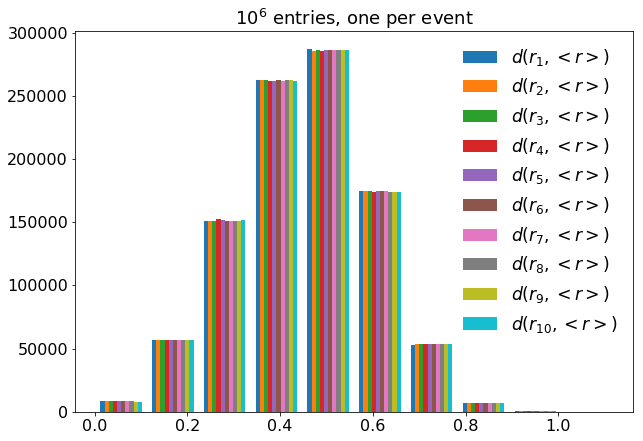

In [23]:
names = ['$d(r_{'+'{}'.format(i)+'},<r>)$' for i in range(1, 11)]
plt.hist(d_to_mean, label=names)
plt.title('$10^6$ entries, one per event')
plt.legend();

## Pairing 3D vectors for each observation, without a loop

Being able to pair objects is obviously important for many type of calculations. This allows to probe correlations at the first order, to identify sub-systems, etc ... In a traditional way, a pairing would involve a *for* loop in which the combinatorics can be done for each event. Working with numpy, one has to perform the combinatorics in a vectorized way and return a new numpy array containing all the pairs. Once done, one can perform many types of computations on this new array.

### Finding all possible $(r_{i}, r_{j})$ pairs for all events

One solution to perform such a task without *for* loop was found on [stackoverflow](https://stackoverflow.com/questions/16003217/n-d-version-of-itertools-combinations-in-numpy). The idea is to simply work on indices to build the pairs (since it doesn't really matter what are the nature of the objects), and use numpy *fancy* indexing. Let proceed step by step with a smallest array to understand the procedure (namely 2 observations of 5 positions):

In [24]:
a = r[0:2,0:5]
print(a)

[[[0.15624688 0.65075903 0.73146179]
  [0.73724685 0.48307419 0.77974699]
  [0.20971887 0.59327557 0.6531156 ]
  [0.35159907 0.52204891 0.25537105]
  [0.48437309 0.82028797 0.30840494]]

 [[0.91650213 0.05817777 0.01940356]
  [0.70698068 0.85873894 0.84390599]
  [0.86004332 0.36252308 0.98642545]
  [0.40568495 0.01213849 0.67142505]
  [0.42802106 0.34523561 0.97850495]]]


Since we want to work with the indicies of the 5 vectors, we create a numpy array of integer going from 0 to 4 (`a.shape[1]` is the number of elements along the second dimension, *i.e.* 5):

In [25]:
array_indices = np.arange(a.shape[1])
print(array_indices)

[0 1 2 3 4]


Then, we use the package `itertools` to deal with the combinatorics. This will return an *iterator* that can be turned into a numpy array using `np.fromiter()`. But this function requires to specify the data type `dt`, which is done using a structured array synthax here (*i.e.* `[(varName1,type1), (varName2,type2)]`). For more details on data type, check this [documentation page](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.dtypes.html).

In [26]:
dt = np.dtype([('index1', np.intp), ('index2', np.intp)])
print(dt)

[('index1', '<i8'), ('index2', '<i8')]


In [27]:
array_indice_comb = np.fromiter(itertools.combinations(array_indices, 2), dt)
print(array_indice_comb)

[(0, 1) (0, 2) (0, 3) (0, 4) (1, 2) (1, 3) (1, 4) (2, 3) (2, 4) (3, 4)]


The next step is to format these numbers in a indices array with the proper dimension, so that when we do `a[indices]`, we get all the pairs. For instance, we need to have all 10 pairs, each with two elements corresponding to a shape `indices.shape=(10,2)`. We can achieved this in two steps:

   1. `array_indice_comb.view(np.intp)` return the exact same data of `array_indice_comb` as a 1D array of positive integer.
   2. we reshape the resulting array with `reshape(-1, 2)`, where -1 means "compute the size of the first dimension to have 2 objects (we wants pair!) in the second dimension.

In [28]:
indices = array_indice_comb.view(np.intp).reshape(-1, 2)
print(indices)

[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 2]
 [1 3]
 [1 4]
 [2 3]
 [2 4]
 [3 4]]


The final steps is exploit fancy indexing along `axis=1` *i.e.* the 5 spatial positions. In practice, for each observation `iobs`, we want to have `a[iobs, indices]`. There are two ways to do this: (a) `a[:, indices]` or (b) using the numpy function `np.take(a, indices, axis)` which makes the code more independant from the structure of `a`:

In [29]:
a_pairs = np.take(a, indices, axis=1)
print(a_pairs.shape)

(2, 10, 2, 3)


In [30]:
a_pairs = a[:,indices]
print(a_pairs.shape)

(2, 10, 2, 3)


We have now 2 events, each having 10 pairs, each having 2 objects (still a pair!), each having 3 coordinates (spatial positions). We can print all the 10 pairs for the first observation:

In [31]:
print(a_pairs[0])

[[[0.15624688 0.65075903 0.73146179]
  [0.73724685 0.48307419 0.77974699]]

 [[0.15624688 0.65075903 0.73146179]
  [0.20971887 0.59327557 0.6531156 ]]

 [[0.15624688 0.65075903 0.73146179]
  [0.35159907 0.52204891 0.25537105]]

 [[0.15624688 0.65075903 0.73146179]
  [0.48437309 0.82028797 0.30840494]]

 [[0.73724685 0.48307419 0.77974699]
  [0.20971887 0.59327557 0.6531156 ]]

 [[0.73724685 0.48307419 0.77974699]
  [0.35159907 0.52204891 0.25537105]]

 [[0.73724685 0.48307419 0.77974699]
  [0.48437309 0.82028797 0.30840494]]

 [[0.20971887 0.59327557 0.6531156 ]
  [0.35159907 0.52204891 0.25537105]]

 [[0.20971887 0.59327557 0.6531156 ]
  [0.48437309 0.82028797 0.30840494]]

 [[0.35159907 0.52204891 0.25537105]
  [0.48437309 0.82028797 0.30840494]]]


Once understood, we can wrapp-up this code into a function where we generalize the number of objects we want to group `n` and the axis along which we want to group `axis`:

In [32]:
def combs_nd(a, n, axis=0):
    i = np.arange(a.shape[axis])
    dt = np.dtype([('', np.intp)]*n)
    i = np.fromiter(itertools.combinations(i, n), dt)
    i = i.view(np.intp).reshape(-1, n)
    return np.take(a, i, axis=axis)

As a sanity check, we can re-compute `a_pair` and compare with the previous results:

In [33]:
a_pairs = combs_nd(a=r[0:2,0:5], n=2, axis=1)
print(a_pairs[0])

[[[0.15624688 0.65075903 0.73146179]
  [0.73724685 0.48307419 0.77974699]]

 [[0.15624688 0.65075903 0.73146179]
  [0.20971887 0.59327557 0.6531156 ]]

 [[0.15624688 0.65075903 0.73146179]
  [0.35159907 0.52204891 0.25537105]]

 [[0.15624688 0.65075903 0.73146179]
  [0.48437309 0.82028797 0.30840494]]

 [[0.73724685 0.48307419 0.77974699]
  [0.20971887 0.59327557 0.6531156 ]]

 [[0.73724685 0.48307419 0.77974699]
  [0.35159907 0.52204891 0.25537105]]

 [[0.73724685 0.48307419 0.77974699]
  [0.48437309 0.82028797 0.30840494]]

 [[0.20971887 0.59327557 0.6531156 ]
  [0.35159907 0.52204891 0.25537105]]

 [[0.20971887 0.59327557 0.6531156 ]
  [0.48437309 0.82028797 0.30840494]]

 [[0.35159907 0.52204891 0.25537105]
  [0.48437309 0.82028797 0.30840494]]]


It can be intersting to see that this operation takes less than a second for a million observations of 10 vectors, meaning 45 pairs:

In [34]:
%timeit combs_nd(a=r, n=2, axis=1)

935 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Computing (minimum) distances on these pairs

Once we have these pairs, we can for example computes all the distances and find which pair has the closest objects. Starting with the pairs:

In [35]:
pairs = combs_nd(a=r, n=2, axis=1)

We can then define the vectorial difference between the two position of a pair, and compute the euclidiean distance:

In [36]:
dp = pairs[:, :, 0, :]-pairs[:, :, 1, :]
distances = (np.sum(dp**2, axis=2))**0.5

And get the minimum distance for each event:

In [37]:
smallest_distance = np.min(distances, axis=1)
print(smallest_distance.shape)

(1000000,)


All these instructions can be put into a function which can be timed:

In [38]:
def compute_dr_min(a):
    pairs = combs_nd(a, 2, axis=1)
    i1 = tuple([None, None, 0, None])
    i2 = tuple([None, None, 1, None])
    return np.min(np.sum((pairs[i1]-pairs[i2])**2, axis=2)**0.5, axis=1)

In [39]:
%timeit compute_dr_min(r)

949 ms ± 6.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that doing all operations in the less possible amount of lines can significantly speed up the process. Let's define another function where the difference between the pair elements is done separately:

In [40]:
def compute_dr_min_more_steps(a):
    pairs = combs_nd(a, 2, axis=1)
    dp = pairs[:, :, 0, :]-pairs[:, :, 1, :]
    return np.min(np.sum(dp**2, axis=2)**0.5, axis=1)

And let's compare the performance on 0.2 million observations:

In [41]:
%timeit compute_dr_min(a=r[:200000])
%timeit compute_dr_min_more_steps(a=r[:200000])

193 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
619 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's now plot the distributions of all distances for all the pairs (using `flatten()` function which returns a 1D array), and only the pair having the smallest distances:

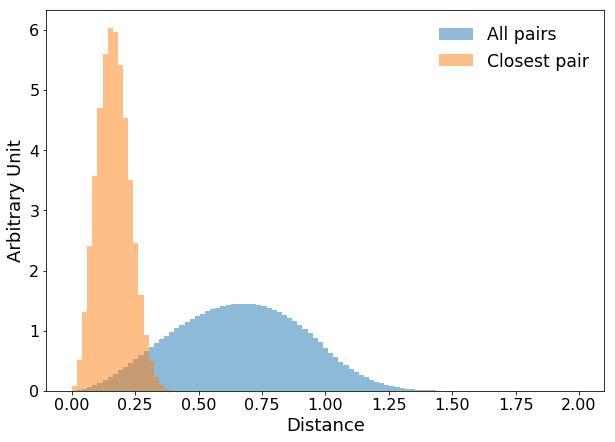

In [42]:
plot_style = {
    'bins': np.linspace(0, 2, 100),
    'alpha': 0.5,
    'density': True,
}

plt.hist(distances.flatten(), label='All pairs' ,**plot_style)
plt.hist(smallest_distance, label='Closest pair', **plot_style)
plt.xlabel('Distance')
plt.ylabel('Arbitrary Unit')
plt.legend();

## Selecting a subset of $r_i$ based on $(x,y,z)$ values, without loop

The next step in our exploration "loop-less calculations" is to be able to perform the same kind of computation described above but only on a subset of positions, selected according to a given criteria. For example, we might want to keep particles only if there have positive charge. Many obvious application can be found in other physics field and/or machine learning. Let's start with accessing the three arrays of coordinates in order to select points based on some easy criteria.

In [43]:
x, y, z = r[:, :, 0], r[:, :, 1], r[:, :, 2]

### Counting number of points amont the 10 with $x_i>y_i$ in each event

We will use the numpy masking feature described in the first chapter, defining a index of boolean based on `x` and `y` arrays:

In [44]:
idx = x > y
print(idx.shape)

(1000000, 10)


We can quickly check the distribution for the selected coordinates: $x$ and $y$ are anty correlated - as expected - while $z$ is flat - as expected.

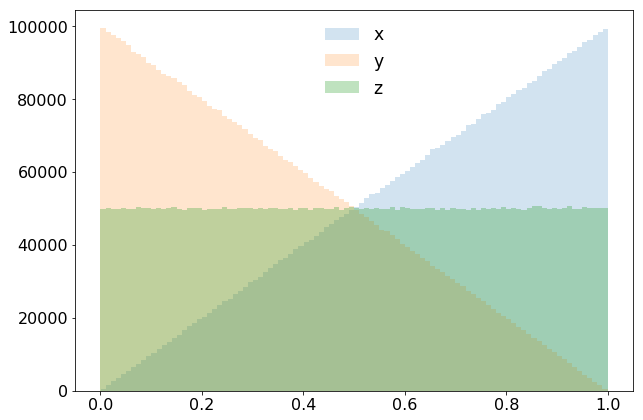

In [46]:
plt.hist(x[idx], bins=100, alpha=0.2, label='x')
plt.hist(y[idx], bins=100, alpha=0.2, label='y')
plt.hist(z[idx], bins=100, alpha=0.3, label='z')
plt.legend();

If we want to better understand how this selection affect our data, one might want to count the number of points per event satisfying this selection, using `np.count_nonzero()` on the boolean array along the axis representing the 10 vectors `axis=1`:

In [47]:
c = np.count_nonzero(idx, axis=1)
print(c.shape)

(1000000,)


We can then plot the distribution of this number over all the events:

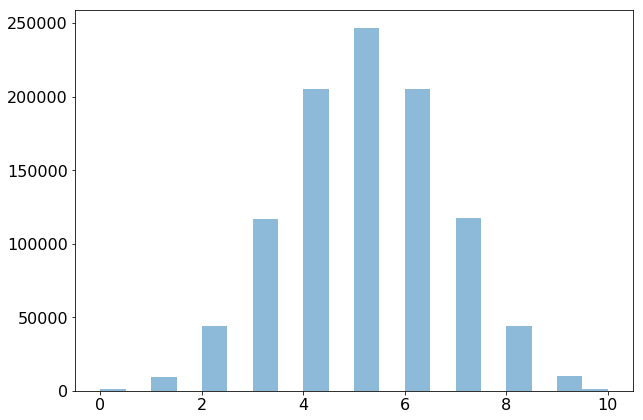

In [49]:
plt.hist(c, bins=20, alpha=0.5);

### Plotting $z$ for the two types of population  ($x>y$ and $x<y$)

This is obviously useful to inspect the different populations - something we want to do very often. For the plotting purpose, let's consider only the 500 first observations that we dump into `sx`, `sy`, `sz` (`s` for small):

In [50]:
sx, sy, sz = x[0:500, ...], y[0:500, ...], z[0:500, ...]

We define the mask computed on these small arrays `smask`:

In [51]:
smask = sx>sy

And we can plot the result in the 2D plane $(x,y)$ with the $z$ coordinate as marker size, for instance $1/(z+10^{-3})$. The two populations are defined using both `smask` and `~smask` to make sure the union of the two is the original dataset:

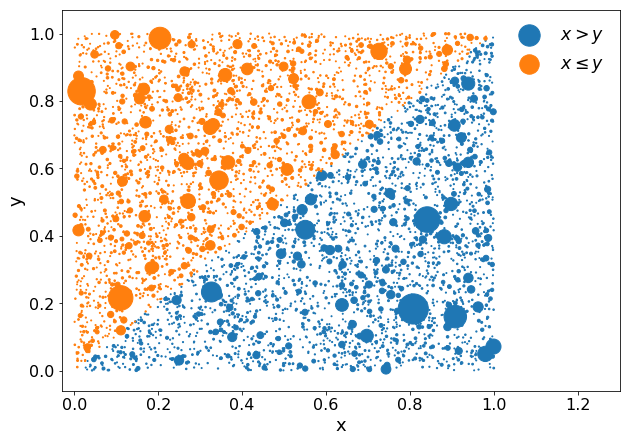

In [53]:
plt.scatter(sx[smask], sy[smask], s=(sz[smask]+1e-3)**-1, label='$x>y$')
plt.scatter(sx[~smask], sy[~smask], s=(sz[~smask]+1e-3)**-1, label='$x\leq y$')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.03, 1.3)
plt.legend();

### Computation of  $x_i+y_i+z_i$ sum over  a subset of the 10 positions

Once we are able to isolate a subset of points, we might to computes new numbers only based on those. This is what is proposed here with the sum of the three coordintates. Let's first compute and the sum, called `ht`, over all the 10 points:

In [54]:
ht1 = np.sum(x+y+z, axis=1)
print(ht1.shape)

(1000000,)


Apply now a selection, which multiply the value by 0 (*i.e.* `False`) if the condition is not satistifed:

In [55]:
selection = x>y
ht2 = np.sum((x+y+z)*selection, axis=1)

Of course, this works only for computation which is not affected by a 0: if we want to compute the product of coordinate, this approach will obvioulsy not work.

In [56]:
prod = np.product((x+y+z)*selection, axis=1)
eff = np.count_nonzero(prod>0)/len(prod)
print('Efficiency of prod>0: {:.5f}'.format(eff))

Efficiency of prod>0: 0.00100


In a more general manner, we should use *masked arrays* which completely remove the masked elements from any computations:

In [57]:
mx = np.ma.array(x, mask=selection)
my = np.ma.array(y, mask=selection)
mz = np.ma.array(z, mask=selection)
prod = np.product((mx+my+mz), axis=1)
eff = np.count_nonzero(prod>0)/len(prod)
print('Efficiency of prod>0: {:.5f}'.format(eff))

Efficiency of prod>0: 1.00000


Finally one can plot the result, removing the observation with `ht2==0` (case where all the 10 points have $x\leq y$):

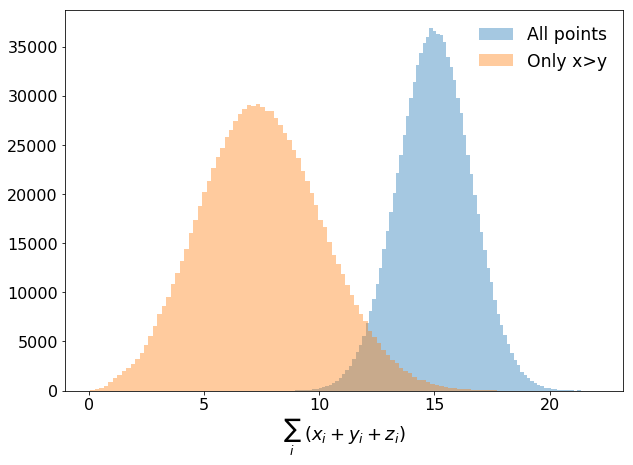

In [58]:
plt.hist(ht1, bins=100, alpha=0.4, label='All points')
plt.hist(ht2[ht2>0], bins=100, alpha=0.4, label='Only x>y')
plt.xlabel('$\sum_{i} \; (x_i+y_i+z_i)$')
plt.legend();

### Pairing with a subset of $r_i$ verifying $x_i>y_i$ only

Another computation would be to redo the pairing on the subset of selected position. In order to do so, we follow the same logic, expect that we will directly replace removed values by `nan` in order to be easily identifiable in after the pairing. It's *very important to copy the orignal data with the module `copy`*, otherwise, the orignal data will be modifed in the following piece of code:

In [59]:
import copy
selection = x>y
selected_r = copy.copy(r)
selected_r[selection] = np.nan
print(selected_r[0])

[[0.15624688 0.65075903 0.73146179]
 [       nan        nan        nan]
 [0.20971887 0.59327557 0.6531156 ]
 [0.35159907 0.52204891 0.25537105]
 [0.48437309 0.82028797 0.30840494]
 [0.02253355 0.74355187 0.49186388]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [0.25564683 0.6235393  0.74733499]]


On can now calling the paring function on the filtered dataset:

In [60]:
selected_pairs = combs_nd(selected_r, n=2, axis=1)

And compute the distances, but replacing back the `np.nan` by a default values that will not be seen on a plot.

In [61]:
p1, p2 = pairs[:, :, 0, :], pairs[:, :, 1, :]
dp = np.sum((p1-p2)**2, axis=2)**0.5
dp[np.isnan(dp)] = 999

And plotting the distributions of both all distances and minimum distances for pairs made out of points verifying $x>y$:

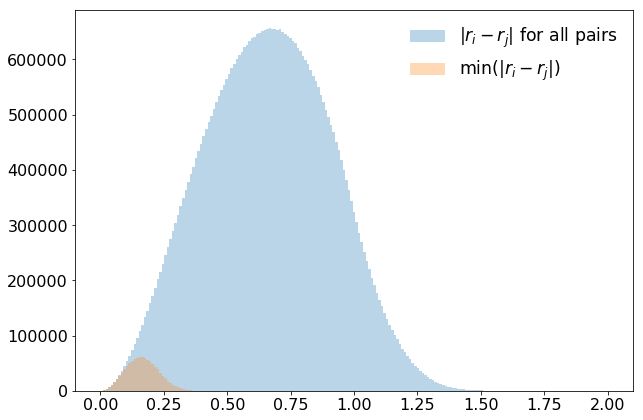

In [63]:
plot_style = {'bins': np.linspace(0, 2, 200), 'alpha':0.3}
plt.hist(dp.flatten(), label='$|r_i-r_j|$ for all pairs', **plot_style)
plt.hist(np.min(dp, axis=1), label='min$(|r_i-r_j|)$', **plot_style)
plt.legend();

## Some comments

Manipulating numpy array is quite powerful and fast for both computation and plotting, at the condition that we use numpy optimization, namely vectorization, indexing and broadcasting. This is ofter possible when this has also some limitations as we saw above. Namely, we add to play a bit with "patchwork approaches" to achieve what we want without loops in the last two sections. Typically, what will work for one computation will not work for another (replacing rejected values by 0 works for an addition and not for a product). For the pairing as well, we had to replace all rejected values by `np.nan` in order to filter them later on. This kind of practice makes things less readable when complexity increases - according to me. Or maybe there are smarter ways to do things.